In [18]:
# ------------------------------------------------
# Choix des tailles de matrice (Q, K, V) et d
# ------------------------------------------------
seq_len, d_model = 2048, 64


# ------------------------------------------------
# Choix des tailles de blocs à tester 
# ------------------------------------------------
x = np.random.randn(seq_len, d_model)
min_size, max_size, step = 64, 512, 64
blocks = list(range(min_size, max_size + step, step))

## Calcul de l'attention (avec numpy)

In [19]:
import numpy as np
import pandas as pd
import time
import math
from math import sqrt
from scipy.stats import t as student_t
import matplotlib.pyplot as plt

In [20]:
# ------------------------
# Fonction d'attention (inchangée)
# ------------------------
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / e_x.sum(axis=-1, keepdims=True)

def run_attention_once_np(x, block_size):
    seq_len, d_model = x.shape
    output = np.zeros_like(x)
    for i in range(0, seq_len, block_size):
        end = min(i + block_size, seq_len)
        Q = x[i:end]
        K = x[i:end]
        V = x[i:end]
        scores = np.matmul(Q, K.T) / np.sqrt(d_model)
        weights = softmax(scores)
        output[i:end] = np.matmul(weights, V)
    return output


# ------------------------
# Mesure de temps
# ------------------------
def measure_time(x, block_size):
    start = time.perf_counter()
    _ = run_attention_once_np(x, block_size)
    return time.perf_counter() - start

## Grille exhaustive qui teste toutes les combinaisons

* Mesure initiale : pour chaque block_size, effectue initial_repeats mesures et stocke les temps.

* Choix du candidat : identifie le bloc dont la moyenne des temps initiaux est la plus faible.

* Échauffement : relance 5 mesures supplémentaires sur ce “best” pour estimer son intervalle de confiance (IC) à 95 % (Student-t).

* Itération : jusqu’à max_iter, répète :

* Recalcule la moyenne, l’écart-type et l’IC supérieur du “best”.

* Sélectionne tous les blocs dont la moyenne courante ≤ IC supérieur.

* Mesure chacun de ces candidats une fois de plus.

* Met à jour le “best” en choisissant, parmi les candidats, celui à la plus petite moyenne.

* Test de confiance : pour chaque autre bloc, effectue un test t de Welch contre le “best” et calcule la p-value unilatérale.

* Arrêt : dès que toutes les p-values sont < 0.05 (95 % de confiance que le “best” est plus rapide), on sort.

* Résultat : retourne la taille de bloc optimale, toutes les mesures accumulées, et le nombre total de tests effectués.

In [21]:
from benchmark import exhaustive_grid_until_confidence

best, results, total_tests, best_track, best_meas, p_hist, measure_per_iter = \
    exhaustive_grid_until_confidence(
        x, blocks,
        initial_repeats=4,
        free_runs=20,
        confidence=0.95,
        max_iter=1000,
        verbose=True
    )


⚙️  Phase 0 : 20 free runs
Fin des free runs

🔍 Phase 1 : mesures initiales
Bloc 64   → médiane init : 0.00449 s
Bloc 128  → médiane init : 0.00838 s
Bloc 192  → médiane init : 0.00626 s
Bloc 256  → médiane init : 0.01207 s
Bloc 320  → médiane init : 0.01047 s
Bloc 384  → médiane init : 0.01210 s
Bloc 448  → médiane init : 0.01825 s
Bloc 512  → médiane init : 0.04708 s

🔁 Itération 1 : mesure de tous les blocs
 Bloc 64   → 0.00525 s (n=5)
 Bloc 128  → 0.00638 s (n=5)
 Bloc 192  → 0.00905 s (n=5)
 Bloc 256  → 0.07187 s (n=5)
 Bloc 320  → 0.01066 s (n=5)
 Bloc 384  → 0.01207 s (n=5)
 Bloc 448  → 0.07518 s (n=5)
 Bloc 512  → 0.01561 s (n=5)
 Meilleur moyen actuel : Bloc 64 (mean=0.00484)
  -> Bloc 64 vs Bloc 128: p=0.1464
  -> Bloc 64 vs Bloc 192: p=0.0100
  -> Bloc 64 vs Bloc 256: p=0.0539
  -> Bloc 64 vs Bloc 320: p=0.0721
  -> Bloc 64 vs Bloc 384: p=0.0752
  -> Bloc 64 vs Bloc 448: p=0.0351
  -> Bloc 64 vs Bloc 512: p=0.0385

🔁 Itération 2 : mesure de tous les blocs
 Bloc 64   → 0.0051

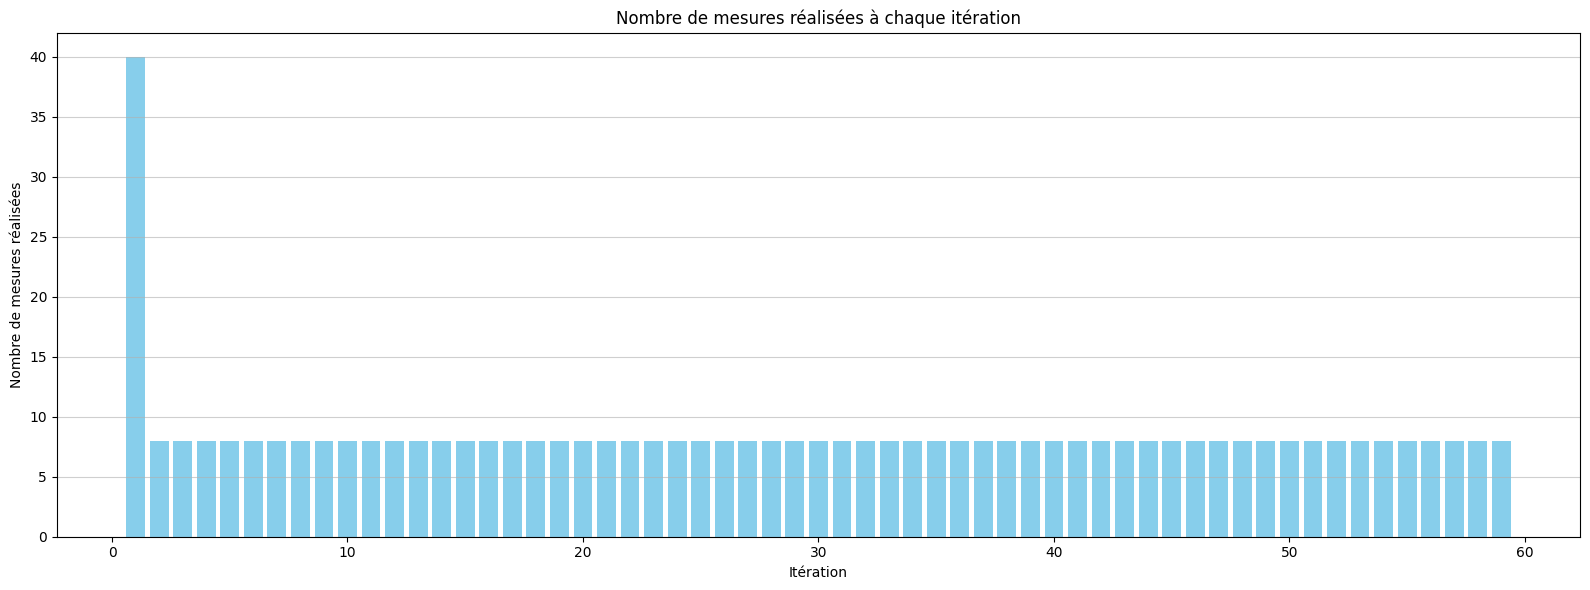

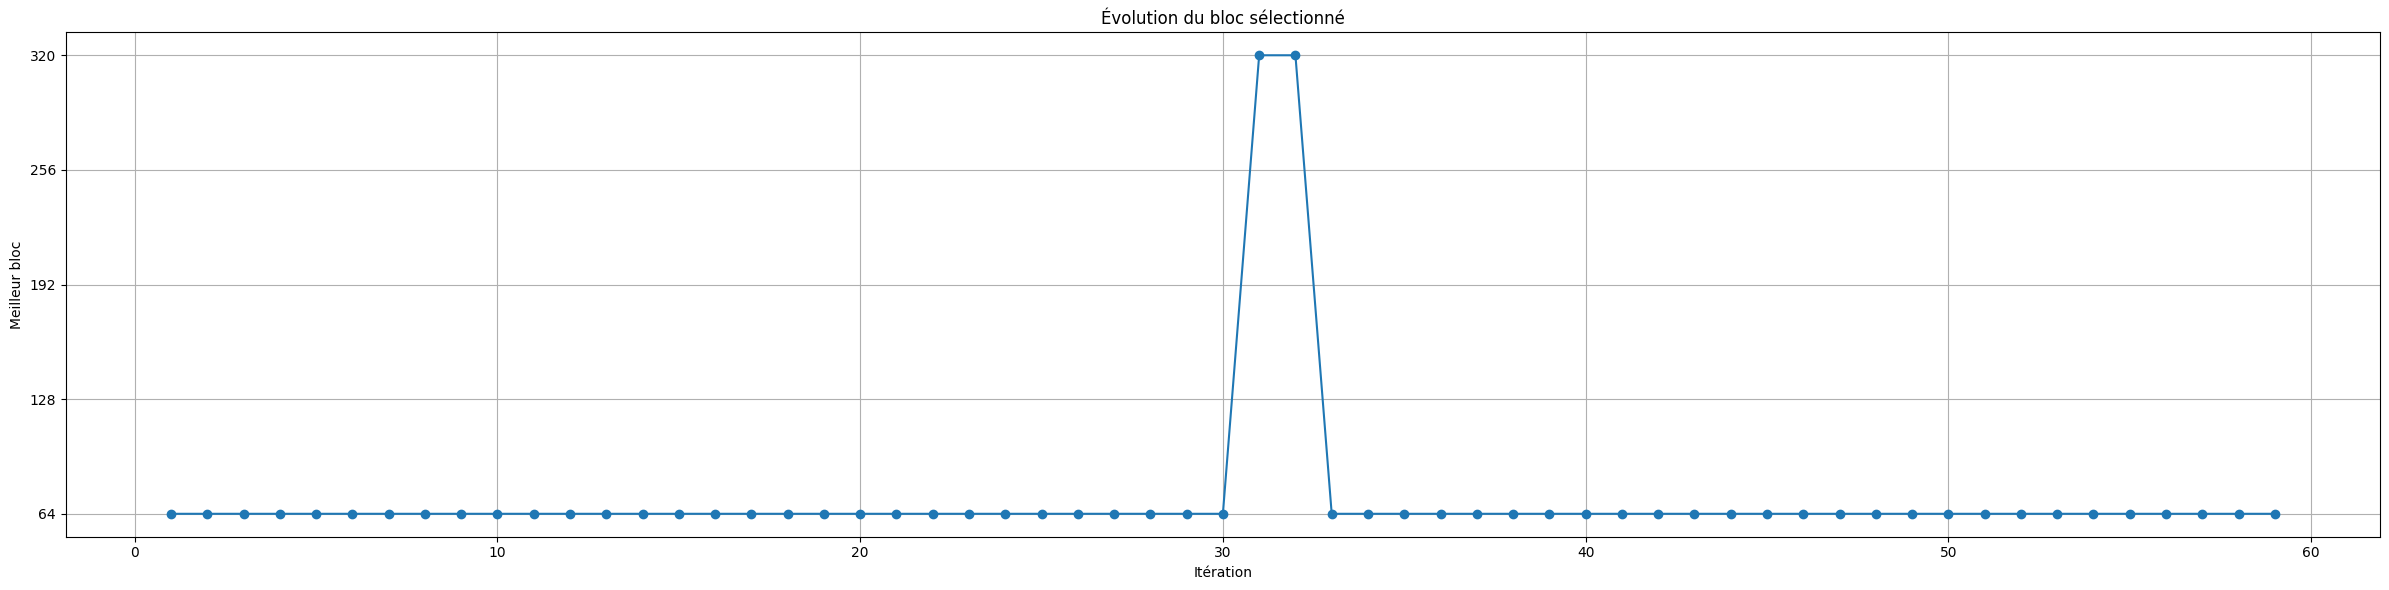

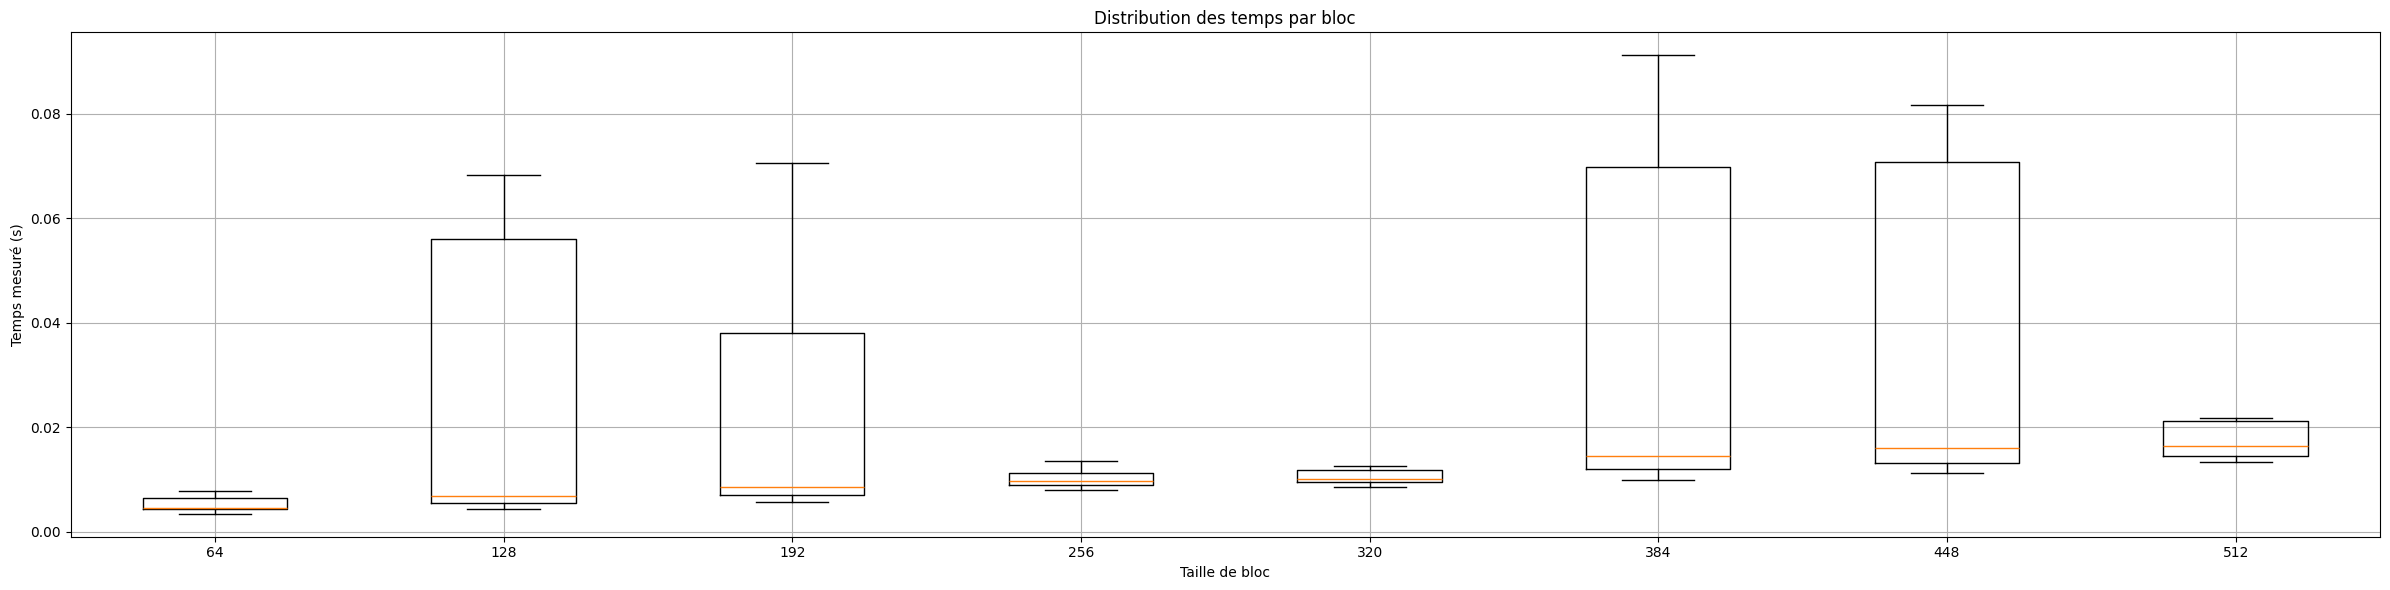

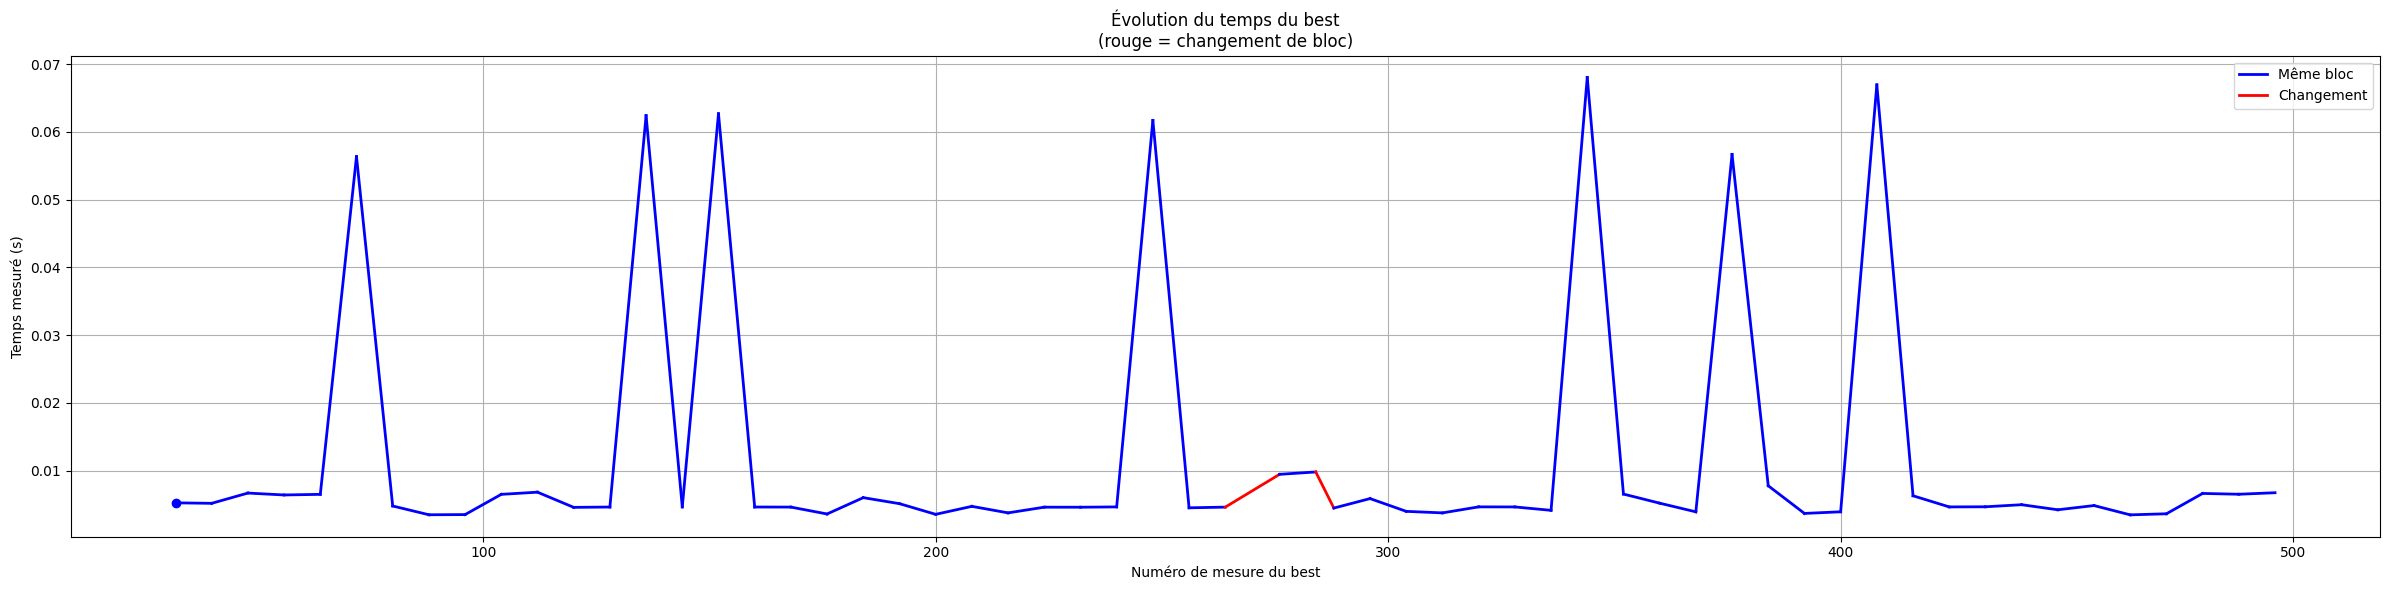

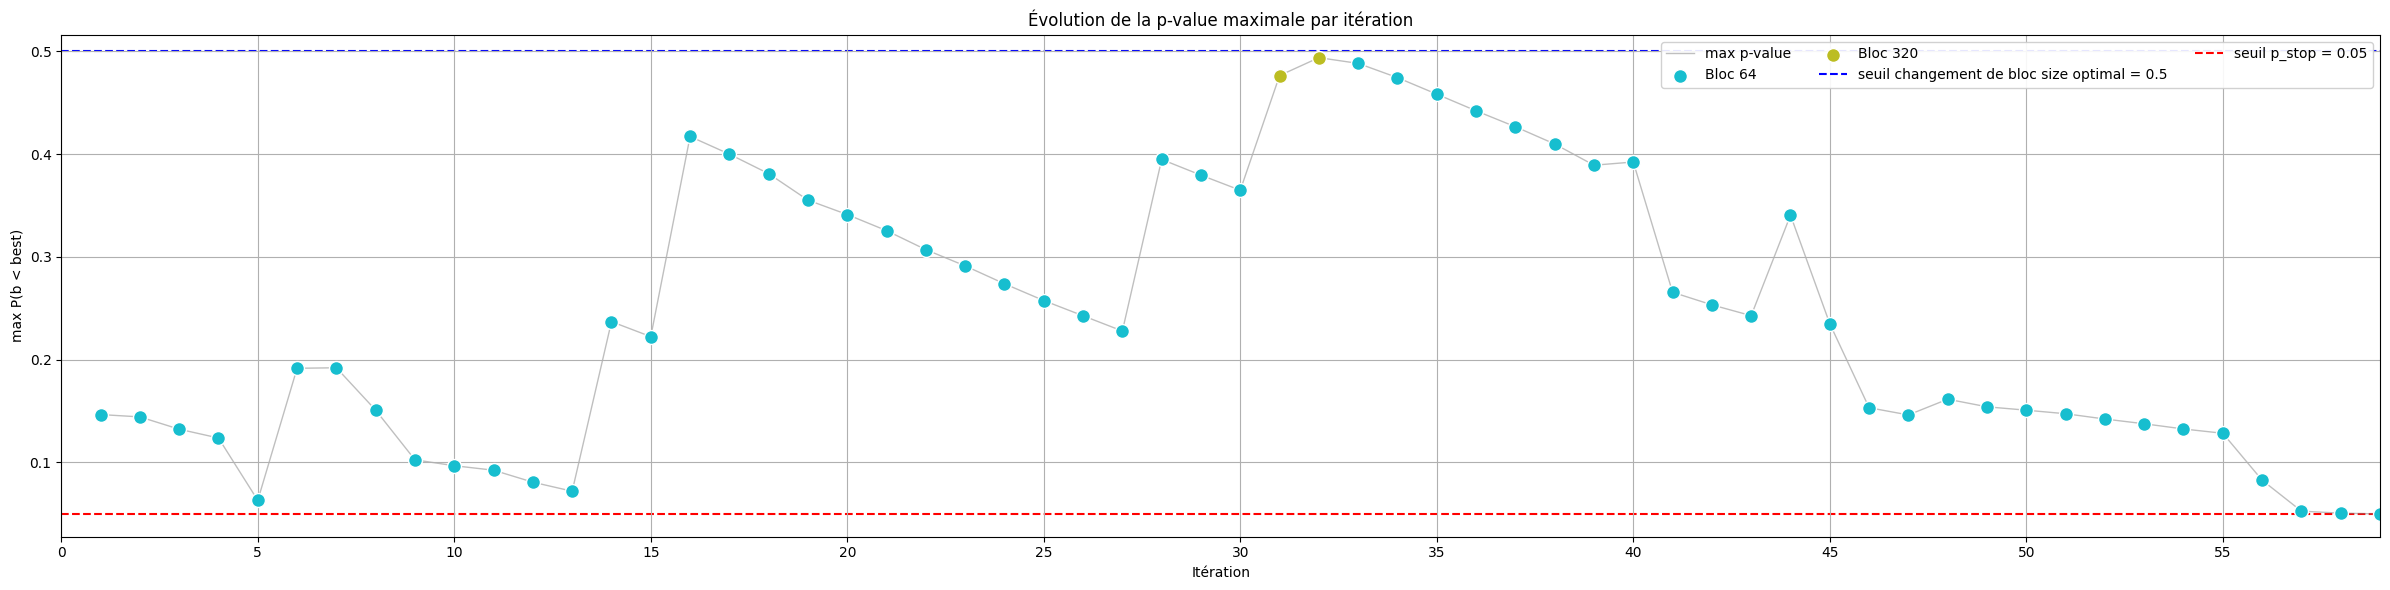

In [22]:
from graphique import plot_all_graphs

plot_all_graphs(
    blocks,
    best_track,
    best_meas,
    results,
    measure_per_iter,
    p_hist,
    step=step,
    figsize=(24, 6)
)

## Meilleur Benchmark

In [23]:
from benchmark import smart_benchmark_probabilistic


best, results, total_tests, best_track, best_meas, p_hist, measure_per_iter = \
    smart_benchmark_probabilistic(
        x, blocks,
        initial_repeats=4,
        free_runs=20,
        confidence=0.95,
        max_iter=1000,
        verbose=True
    )

⚙️  Phase 0 : 20 free runs


Fin des free runs

🔍 Phase 1 : mesures initiales
Bloc 64   → 0.01890 s (n=4)
Bloc 128  → 0.00595 s (n=4)
Bloc 192  → 0.02207 s (n=4)
Bloc 256  → 0.00807 s (n=4)
Bloc 320  → 0.01290 s (n=4)
Bloc 384  → 0.01003 s (n=4)
Bloc 448  → 0.02342 s (n=4)
Bloc 512  → 0.04581 s (n=4)

Best initial : 128

🔁 Itération 1: best = 128
  P(64 plus rapide que 128) = 0.215
  P(192 plus rapide que 128) = 0.177
  P(256 plus rapide que 128) = 0.004
  P(320 plus rapide que 128) = 0.089
  P(384 plus rapide que 128) = 0.000
  P(448 plus rapide que 128) = 0.116
  P(512 plus rapide que 128) = 0.057
Mesures supplémentaires : [128, 64, 192, 320, 448, 512]
  (extra) Bloc 128  → 0.00605 s (n=6)
  Bloc 128  → 0.06434 s (n=7)
  Bloc 64   → 0.00821 s (n=5)
  Bloc 192  → 0.00831 s (n=5)
  Bloc 320  → 0.00971 s (n=5)
  Bloc 448  → 0.01199 s (n=5)
  Bloc 512  → 0.07859 s (n=5)

🔁 Itération 2: best = 128
  P(64 plus rapide que 128) = 0.435
  P(192 plus rapide que 128) = 0.370
  P(256 plus rapide que 128) = 0.762
  P(320 plu

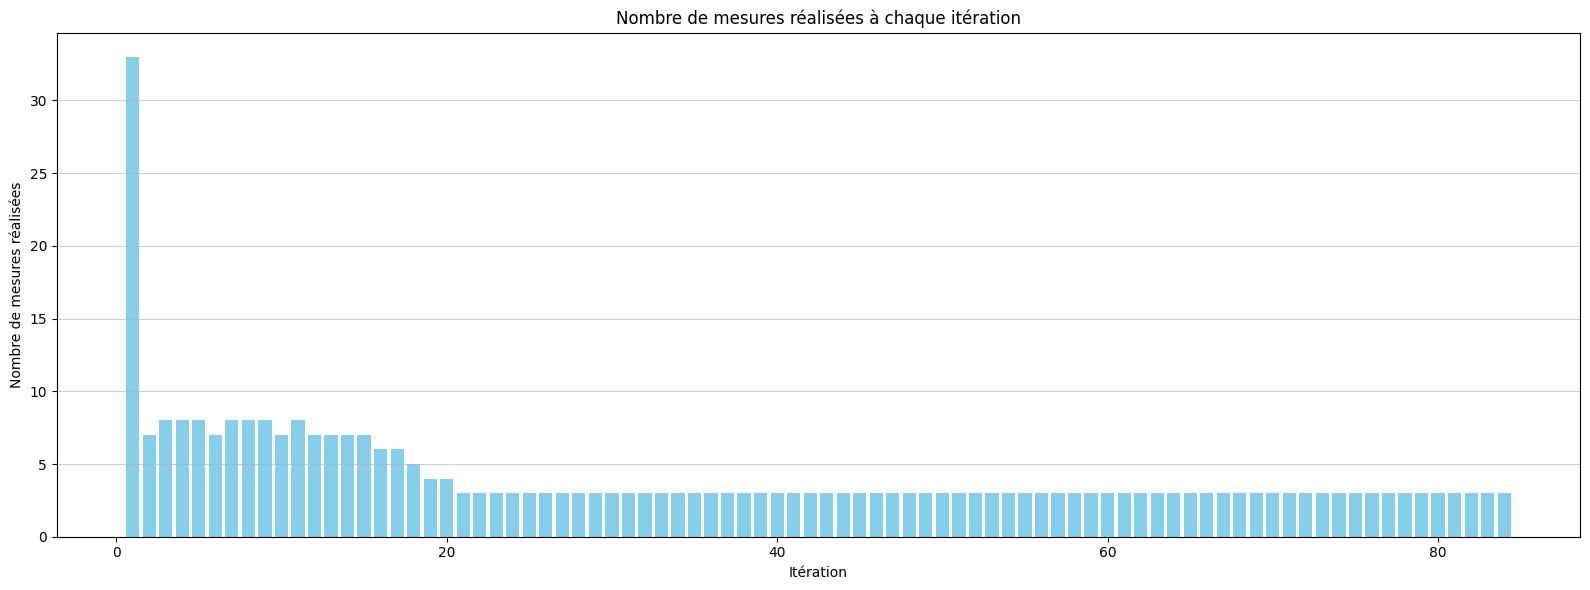

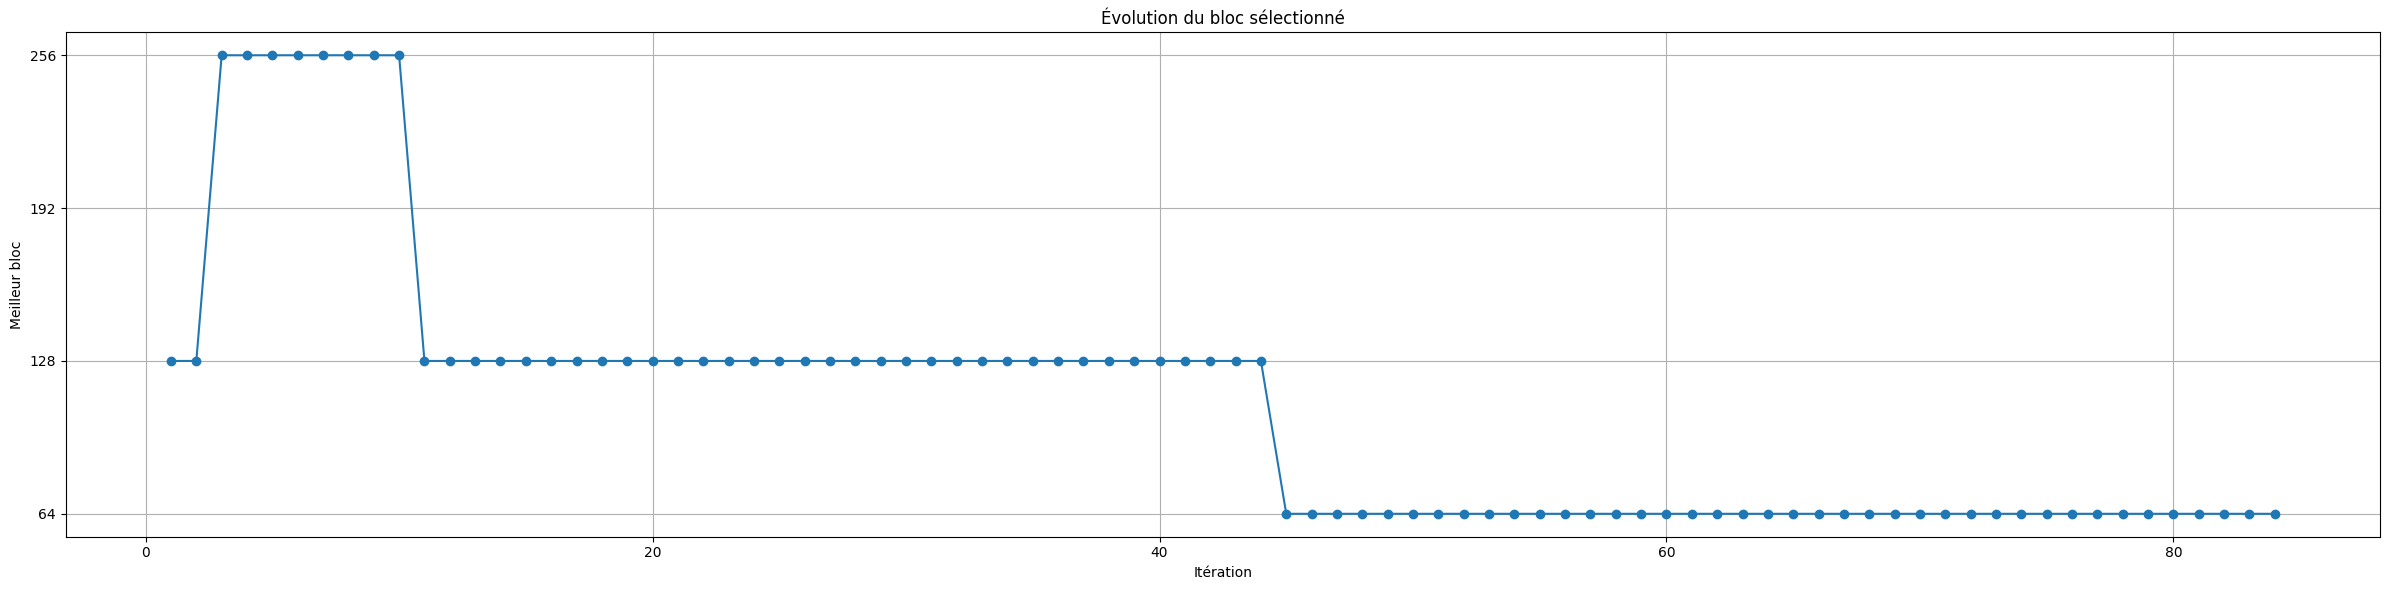

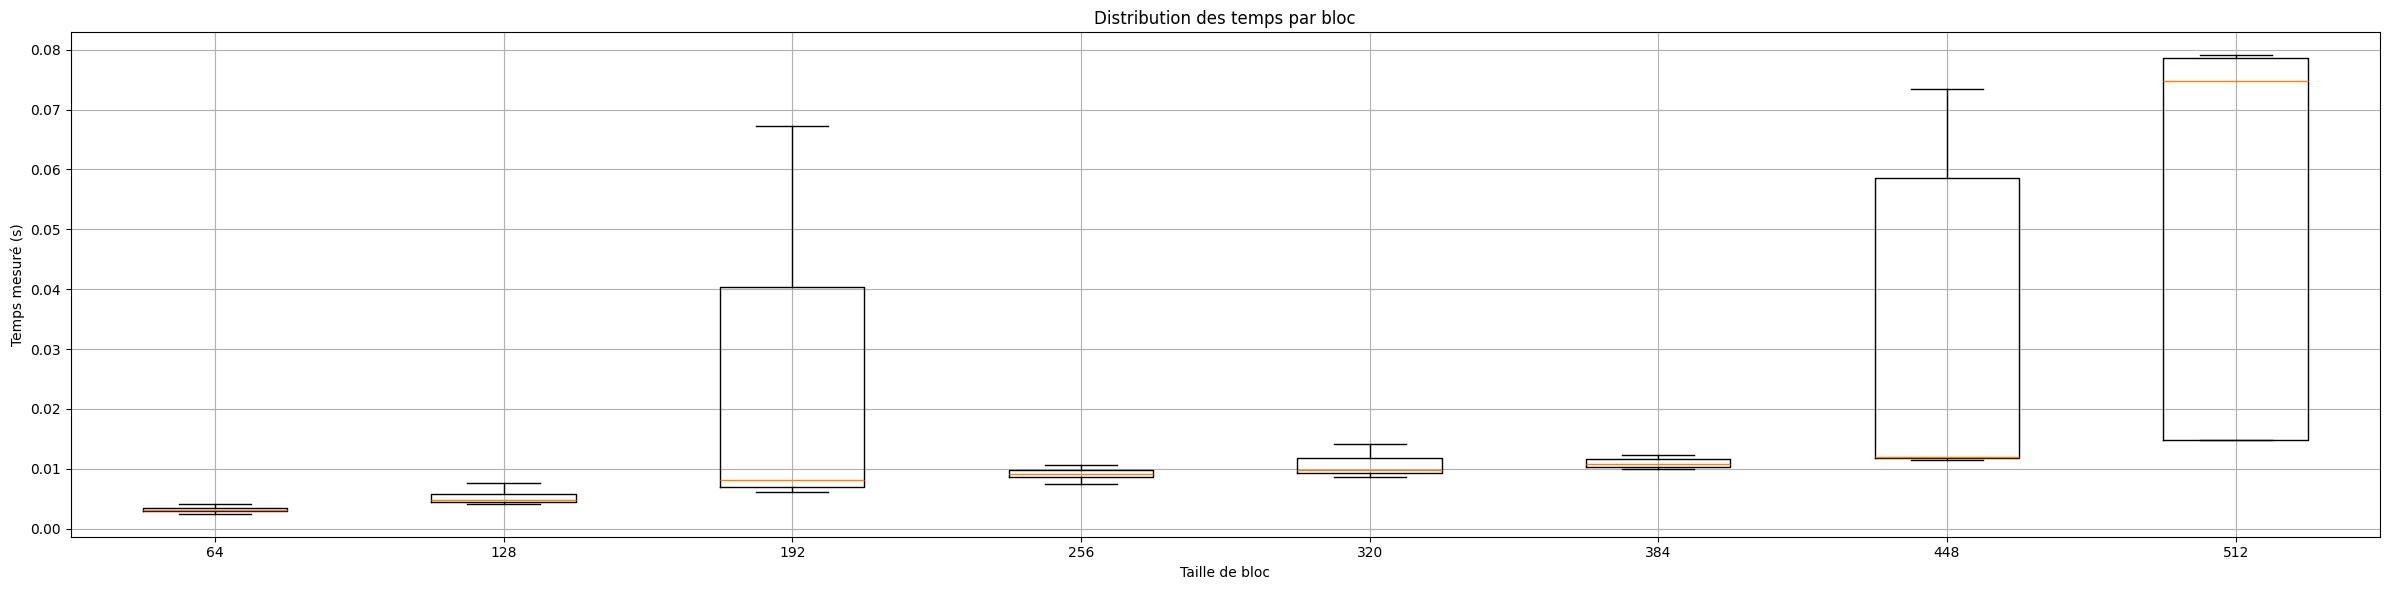

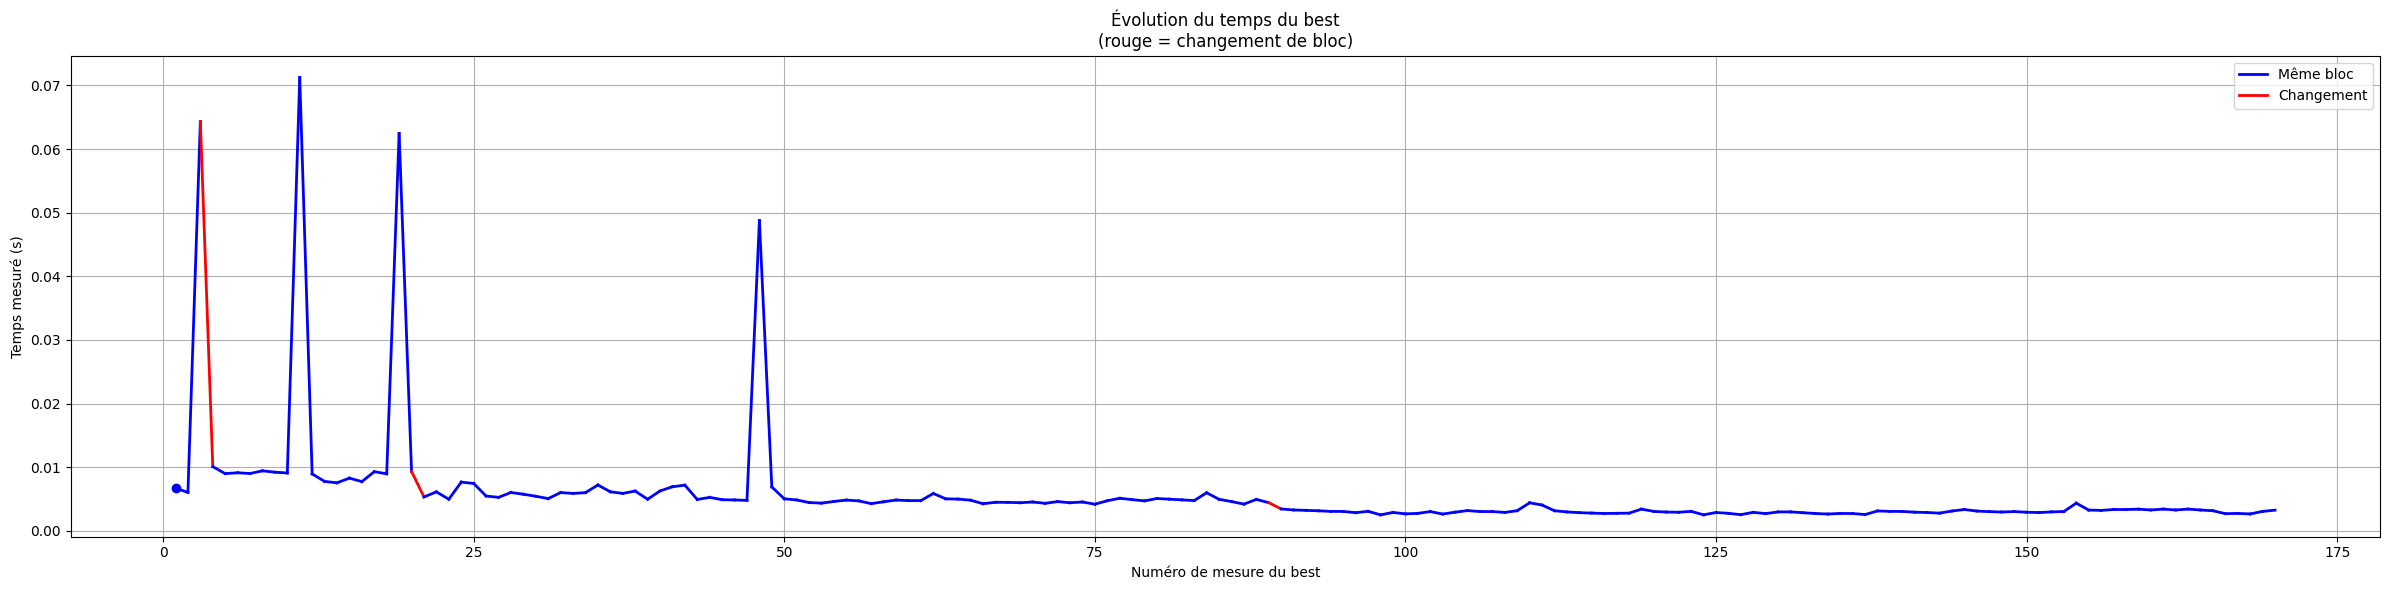

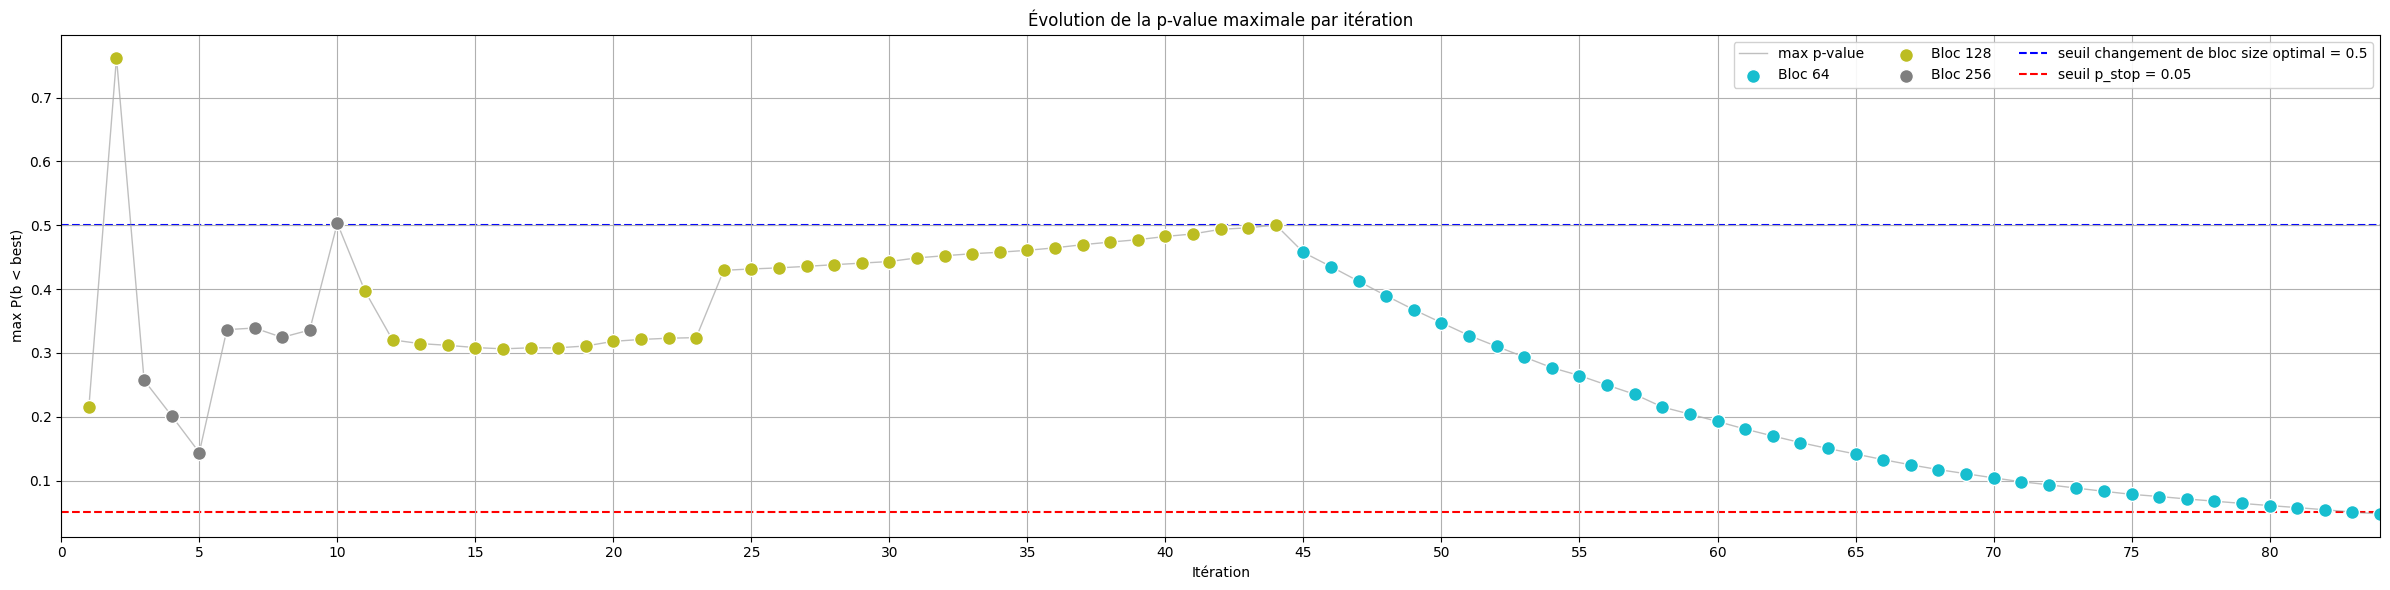

In [24]:
from graphique import plot_all_graphs

plot_all_graphs(
    blocks,
    best_track,
    best_meas,
    results,
    measure_per_iter,
    p_hist,
    step=step,
    figsize=(24, 6)
)